In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.metrics import mean_absolute_percentage_error, mean_absolute_error, r2_score

file_path = './datasets/turkey_cars.csv'
cars_data = pd.read_csv(file_path, encoding='ISO-8859-9')
cars_data.columns = cars_data.columns.str.replace('?', 'i')

# Separate the target variable (y) from the predictors (X)
cars_data_with_color = cars_data.copy().drop(['Fiyat'], axis=1)
X = cars_data.drop(columns=['Fiyat', 'ilan Tarihi', 'Renk'], axis=1)
y = cars_data['Fiyat']

print(X.columns.values)
print(y.values)

['Marka' 'Arac Tip Grubu' 'Arac Tip' 'Model Yil' 'Yakit Turu' 'Vites'
 'CCM' 'Beygir Gucu' 'Kasa Tipi' 'Kimden' 'Durum' 'Km']
[634500 151500  19750 ...  19000  11000  15750]


In [2]:

# Selecting categorical columns with relatively low cardinality for one-hot encoding
categorical_cols = [cname for cname in X.columns if X[cname].nunique() < 100 and 
                    X[cname].dtype == "object" and cname not in ['ilan Tarihi', 'Renk']]

# Selecting numerical columns
numerical_cols = [cname for cname in X.columns if X[cname].dtype in ['int64', 'float64']]

# Keeping selected columns only
my_cols = categorical_cols + numerical_cols
X = X[my_cols]

print(categorical_cols)
print(numerical_cols)
print(X.columns.values)

['Marka', 'Yakit Turu', 'Vites', 'CCM', 'Beygir Gucu', 'Kasa Tipi', 'Kimden', 'Durum']
['Model Yil', 'Km']
['Marka' 'Yakit Turu' 'Vites' 'CCM' 'Beygir Gucu' 'Kasa Tipi' 'Kimden'
 'Durum' 'Model Yil' 'Km']


In [3]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

print(X_train.shape)
print(X_test.shape)

print(X_train[0:5]['Km'])

(7235, 10)
(1809, 10)
949      27000
8626    205000
5734    120000
3807    736000
2201     43000
Name: Km, dtype: int64


In [4]:
from sklearn.preprocessing import OneHotEncoder, StandardScaler 
from sklearn.compose import ColumnTransformer

# Preprocessing for numerical data
numerical_transformer = StandardScaler()  # Data standardization with standard deviation and mean

# Preprocessing for categorical data
categorical_transformer = OneHotEncoder(handle_unknown='ignore')

# Bundle preprocessing for numerical and categorical data
preprocessor = ColumnTransformer(
    transformers=[
        ('num', numerical_transformer, numerical_cols),
        ('cat', categorical_transformer, categorical_cols)
    ])

X_train_transformed = preprocessor.fit_transform(X_train)
X_test_transformed = preprocessor.transform(X_test)

print(X_train_transformed.shape)
print(X_train_transformed[0:5][0][0])

(7235, 100)
  (0, 0)	0.7825217234211116
  (0, 1)	-1.1616885732886089
  (0, 5)	1.0
  (0, 38)	1.0
  (0, 45)	1.0
  (0, 48)	1.0
  (0, 79)	1.0
  (0, 80)	1.0
  (0, 93)	1.0
  (0, 97)	1.0


           Model Yil        Km     Fiyat
Model Yil   1.000000 -0.542959  0.291938
Km         -0.542959  1.000000 -0.279277
Fiyat       0.291938 -0.279277  1.000000


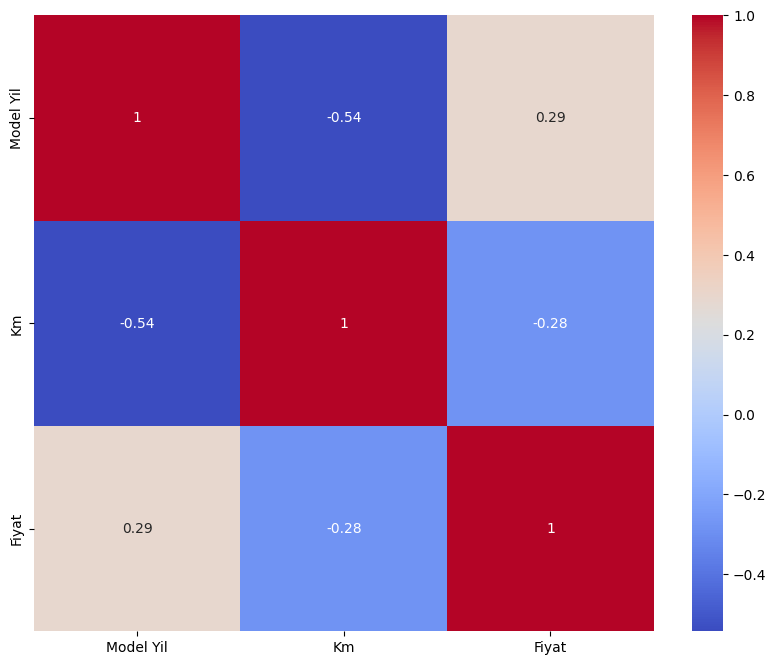

In [5]:
correlation_matrix = cars_data[numerical_cols + ['Fiyat']].corr()

print(correlation_matrix)
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

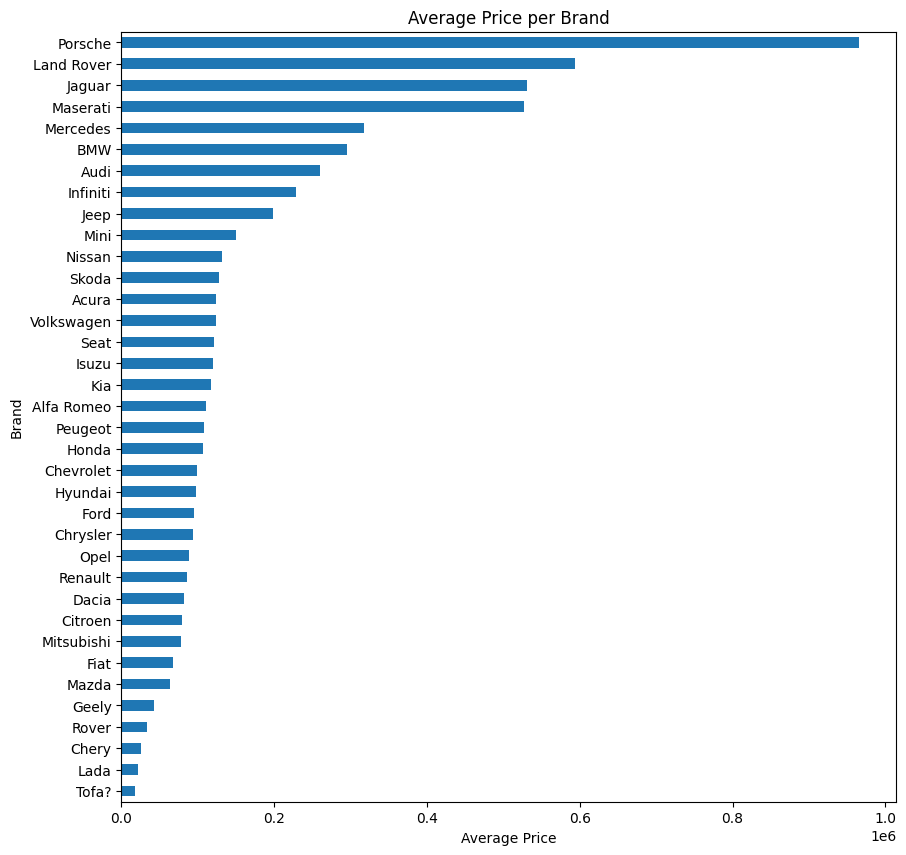

In [6]:
# Calculate the average price for each brand
avg_price_per_brand = cars_data.groupby('Marka')['Fiyat'].mean()

# Sort the results in descending order
avg_price_per_brand = avg_price_per_brand.sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(10, 10))
avg_price_per_brand.plot(kind='barh')
plt.title('Average Price per Brand')
plt.xlabel('Average Price')
plt.ylabel('Brand')
plt.gca().invert_yaxis()  # invert the y-axis to have the highest value at the top
plt.show()

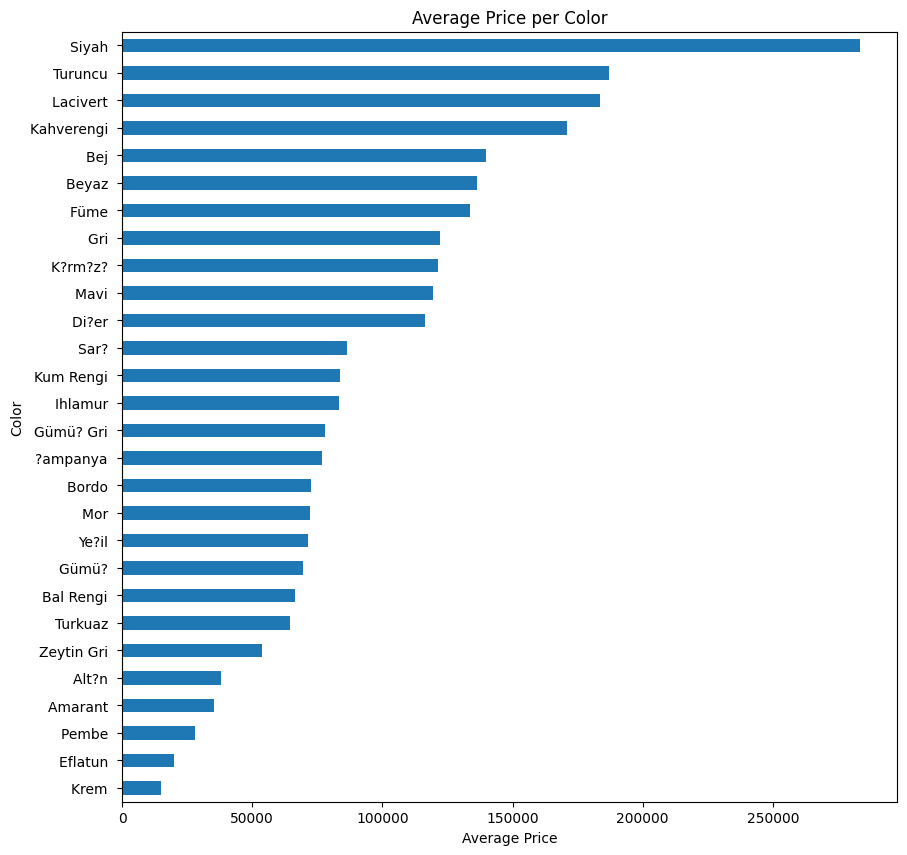

In [7]:
# Calculate the average price for each color
avg_price_per_color = cars_data.groupby('Renk')['Fiyat'].mean()

# Sort the results in descending order
avg_price_per_color = avg_price_per_color.sort_values(ascending=False)

# Plot the results
plt.figure(figsize=(10, 10))
avg_price_per_color.plot(kind='barh')
plt.title('Average Price per Color')
plt.xlabel('Average Price')
plt.ylabel('Color')
plt.gca().invert_yaxis()  # invert the y-axis to have the highest value at the top
plt.show()

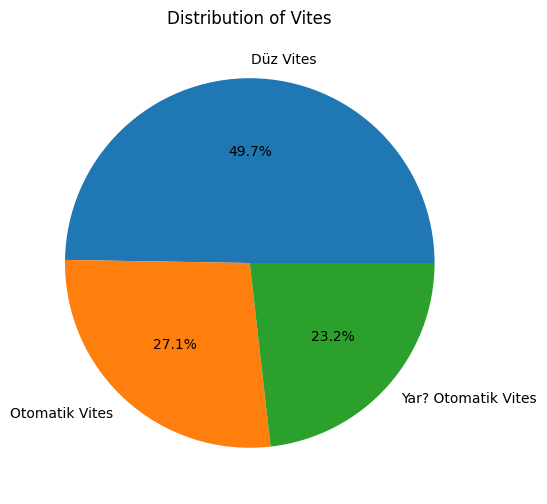

In [8]:
# Count the occurrences of each value in the 'vites' column
vites_counts = cars_data['Vites'].value_counts()

# Plot the results
plt.figure(figsize=(10, 6))
vites_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Distribution of Vites')
plt.ylabel('')  # Hide the y-axis label
plt.show()

In [9]:
# RANDOM FOREST REGRESSION
from sklearn.ensemble import RandomForestRegressor

# Define the model
rf = RandomForestRegressor(n_estimators=100, random_state=0)

# Preprocessing of training data, fit model 
rf.fit(X_train_transformed, y_train)

# Preprocessing of validation data, get predictions
y_pred_rf = rf.predict(X_test_transformed)

print('R2 score for RF:', r2_score(y_test, y_pred_rf))
print('MAE for RF:', mean_absolute_error(y_test, y_pred_rf))
print('MAPE for RF:', mean_absolute_percentage_error(y_test, y_pred_rf) * 100, '%')

R2 score for RF: 0.7976212721832113
MAE for RF: 25359.519902206695
MAPE for RF: 18.668788531124545 %


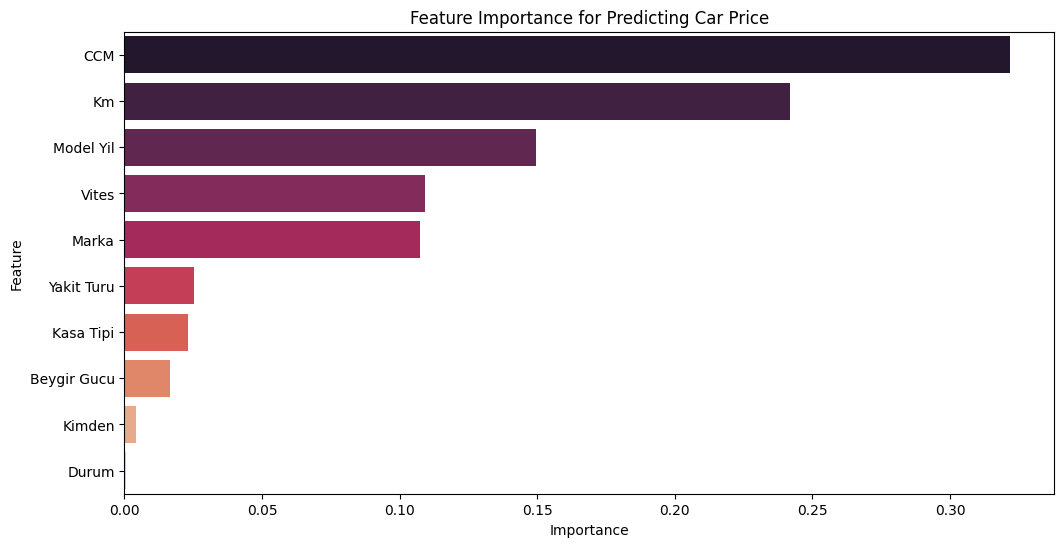

In [10]:
# Extracting feature importances from the model within the pipeline
feature_importances = rf.feature_importances_

# Getting the list of original feature names after one-hot encoding
encoded_features = preprocessor.transformers_[1][1].get_feature_names_out(categorical_cols)
feature_names = numerical_cols + list(encoded_features)

# Mapping these importances back to the original feature names 
# (including aggregating importances for categories of each original categorical feature)
importance_dict = dict(zip(feature_names, feature_importances))
original_feature_importances = {feature: 0 for feature in my_cols}

for feature, importance in importance_dict.items():
    if feature in original_feature_importances:
        original_feature_importances[feature] += importance
    else:
        original_feature_name = feature.split('_')[0]  # Extracting the original feature name before encoding
        original_feature_importances[original_feature_name] += importance

# Sorting the features by importance
sorted_feature_importances = sorted(original_feature_importances.items(), key=lambda x: x[1], reverse=True)

# Converting to DataFrame for easier plotting
df_feature_importances = pd.DataFrame(sorted_feature_importances, columns=['Feature', 'Importance'])

# Plotting
plt.figure(figsize=(12, 6))
sns.barplot(x='Importance', y='Feature', data=df_feature_importances, palette="rocket", hue='Feature')
plt.title('Feature Importance for Predicting Car Price')
plt.xlabel('Importance')
plt.ylabel('Feature')
plt.show()

In [11]:
# SUPPORT VECTOR REGRESSION
from sklearn.svm import SVR

svr = SVR(kernel='linear')
svr.fit(X_train_transformed, y_train)
y_pred_svr = svr.predict(X_test_transformed)

print('R2 score for SVR:', r2_score(y_test, y_pred_svr))
print(f"MAE for SVR: {mean_absolute_error(y_test, y_pred_svr)}")
print('MAPE for SVR:', mean_absolute_percentage_error(y_test, y_pred_svr) * 100, '%')

R2 score for SVR: -0.03541397607391383
MAE for SVR: 84424.0490929514
MAPE for SVR: 59.51288791096879 %


In [12]:
# LINEAR and POLYNOMIAL REGRESSION
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import PolynomialFeatures

pr = PolynomialFeatures(degree=1)
X_poly = pr.fit_transform(X_train_transformed)

lr = LinearRegression()
lr.fit(X_poly, y_train)
X_poly_test = pr.fit_transform(X_test_transformed)

y_pred_poly = lr.predict(X_poly_test)

print(f"R2 score for POLY: {r2_score(y_test, y_pred_poly)}")
print(f"MAE for POLY: {mean_absolute_error(y_test, y_pred_poly)}")
print('MAPE for SVR:', mean_absolute_percentage_error(y_test, y_pred_poly) * 100, '%')

R2 score for POLY: 0.532677482845592
MAE for POLY: 64482.557804577336
MAPE for SVR: 65.17165273360428 %


In [13]:
import numpy as np
from sklearn.inspection import permutation_importance

# Fit your model
lr.fit(X_train_transformed, y_train)

X_test_dense = X_test_transformed.toarray()
print(X_test_dense.shape)
feature_names = preprocessor.get_feature_names_out(input_features=X_train.columns)

# Create a PermutationImportance object
results = permutation_importance(lr, X_test_dense, y_test, scoring='neg_mean_squared_error')

# Get importance
importance = results.importances_mean

# Create a list of (feature, importance) tuples
importances = list(zip(feature_names, importance))

# Filter out features with nan importance
importances = [(feature, score) for feature, score in importances if not np.isnan(score)]

# Calculate the total importance
total_importance = sum(abs(score) for feature, score in importances)

# Calculate weights and create a list of (feature, weight, importance) tuples
importances = [(feature, abs(score) / total_importance, score) for feature, score in importances]

# Sort the importances by weight in descending order
importances.sort(key=lambda x: x[1], reverse=True)

# Summarize feature importance
for feature, weight, importance in importances:
    print('Feature: %s, Weight: %.5f, Score: %.5f' % (feature.split('__')[1], weight, importance))

(1809, 100)
Feature: CCM_1301-1600 cc, Weight: 0.19068, Score: 19083197745.72680
Feature: Yakit Turu_Dizel, Weight: 0.11376, Score: 11384290727.43092
Feature: CCM_1300 cc ve alt?, Weight: 0.09250, Score: 9257468782.33628
Feature: Kimden_Sahibinden, Weight: 0.06022, Score: 6026441678.08357
Feature: Kimden_Galeriden, Weight: 0.05150, Score: 5154411123.18734
Feature: Yakit Turu_Benzin/LPG, Weight: 0.04997, Score: 5001280256.61785
Feature: Yakit Turu_Benzin, Weight: 0.04753, Score: 4756179242.99940
Feature: Model Yil, Weight: 0.04541, Score: 4544525640.21964
Feature: CCM_1601-1800 cc, Weight: 0.04226, Score: 4229418224.56513
Feature: Durum_0 km, Weight: 0.03579, Score: 3581584802.37279
Feature: CCM_3501-4000 cc, Weight: 0.03398, Score: 3400838894.59940
Feature: Marka_Mercedes, Weight: 0.02902, Score: 2904297834.99189
Feature: CCM_1801-2000 cc, Weight: 0.01978, Score: 1979085148.17135
Feature: Beygir Gucu_Bilmiyorum, Weight: 0.01924, Score: 1925731509.02552
Feature: CCM_2001-2500 cc, Weight

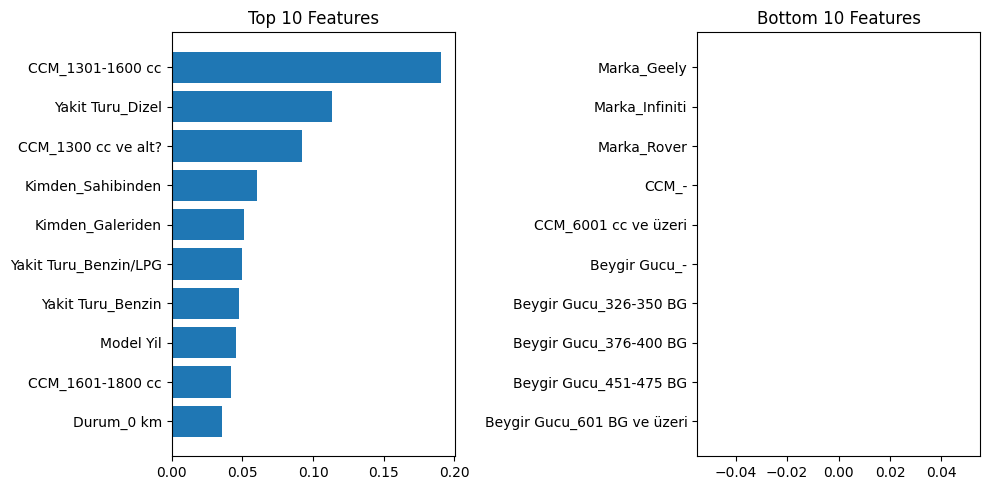

In [14]:
import matplotlib.pyplot as plt

# Get the top 10 and bottom 10 features by weight
top_10 = importances[:10]
bottom_10 = importances[-10:]

# Create a new figure with 2 subplots side by side
fig, axs = plt.subplots(1, 2, figsize=(10, 5))

# Plot the top 10 features
axs[0].barh([x[0].split('__')[1] for x in top_10], [x[1] for x in top_10])
axs[0].set_title('Top 10 Features')
axs[0].invert_yaxis()

# Plot the bottom 10 features
axs[1].barh([x[0].split('__')[1] for x in bottom_10], [x[1] for x in bottom_10])
axs[1].set_title('Bottom 10 Features')
axs[1].invert_yaxis()

# Display the plot
plt.tight_layout()
plt.show()

In [15]:
# RIDGE REGRESSION
from sklearn.linear_model import Ridge

ridge = Ridge(alpha=1)
ridge.fit(X_train_transformed, y_train)
y_pred_ridge = ridge.predict(X_test_transformed)

print(f"R2 score for Ridge: {r2_score(y_test, y_pred_ridge)}")
print(f"MAE for Ridge: {mean_absolute_error(y_test, y_pred_ridge)}")
print('MAPE for Ridge:', mean_absolute_percentage_error(y_test, y_pred_ridge) * 100, '%')

R2 score for Ridge: 0.5337301942646346
MAE for Ridge: 64585.10566722943
MAPE for Ridge: 65.42843690412155 %


In [17]:
# NEURAL NETWORK REGRESSION
from sklearn.neural_network import MLPRegressor

mlp = MLPRegressor(hidden_layer_sizes=(8,16,32,16), activation='relu', solver='adam', max_iter=10000, random_state=42)
mlp.fit(X_train_transformed, y_train)
y_pred_mlp = mlp.predict(X_test_transformed)

print(f"R2 score for MLP: {r2_score(y_test, y_pred_mlp)}")
print(f"MAE for MLP: {mean_absolute_error(y_test, y_pred_mlp)}")
print('MAPE for MLP:', mean_absolute_percentage_error(y_test, y_pred_mlp) * 100, '%')

R2 score for MLP: 0.9290220857622024
MAE for MLP: 24290.169652886198
MAPE for MLP: 19.623914248743308 %
